#트랜스포머(Transformer)

##2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#트랜스포머의 주요 파라미터

1. dmodel = 512
트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기

2. num_layers = 6
트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미

3. num_heads = 8
트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다. 이때 이 병렬의 개수를 의미

4. dff = 2048
트랜스포머 내부에는 피드 포워드 신경망이 존재합니다. 이때 은닉층의 크기를 의미합니다. 피드 포워드 신경망의 입력층과 출력층의 크기는 dmodel의 크기를 가짐

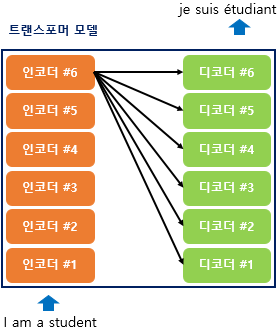

# 1. 인코더

 트랜스포머의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분을 확대해보겠습니다


## 1-1)포지셔널 인코딩
 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 합니다.


 트랜스포머는 위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용
 <br>
 임베딩 벡터 내의 각 차원의 인덱스가 짝수 : 사인 함수<br>
 임베딩 벡터 내의 각 차원의 인덱스가 홀수 : 코사인 함수<br>
 
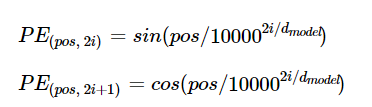

<br>

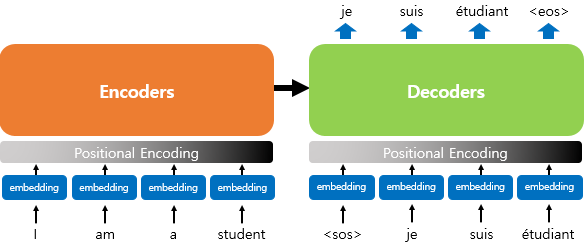

즉, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 **순서 정보가 고려된 임베딩 벡터**


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

50 × 512의 크기를 가지는 포지셔널 인코딩 행렬을 시각화 <br>
입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬

(1, 50, 512)


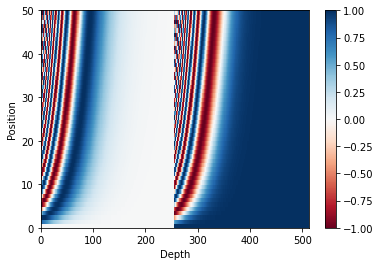

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 512
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 1-2) 어텐션
트랜스포머에서 사용되는 세 가지의 어텐션에 대해서 간단히 정리

1.인코더의 셀프 어텐션 : Query = Key = Value

2.디코더의 마스크드 셀프 어텐션 : Query = Key = Value

3.디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터


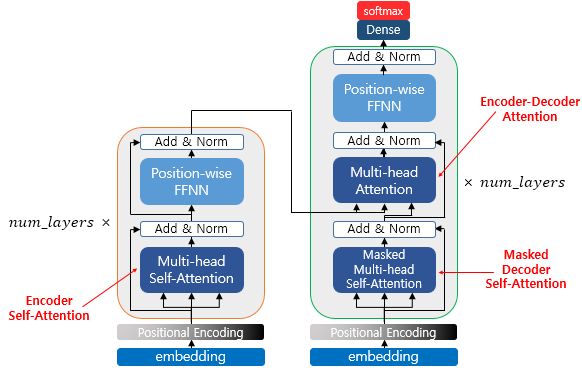

하나의 인코더 층은 크게 총 2개의 서브층(sublayer)으로 구성됨 <br>
1. 셀프 어텐션 <br>
2. 피드 포워드 신경망 

## 1_3) 트랜스포머 셀프 어텐션의  Q, K, V

- 어텐션함수<br>
 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. <br> 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. <br> 그리고 유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴

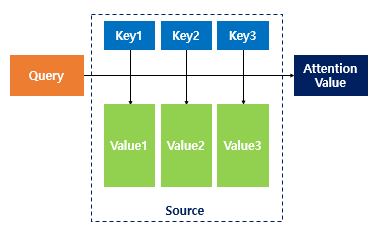 <br>

- seq2seq 어텐션의 Q, K, V
```
Q = Query : t 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
```
- 트랜스포머의 셀프 어텐션 (전체 시점에 대해서 일반화)
```
Q : 입력 문장의 모든 단어 벡터들
K : 입력 문장의 모든 단어 벡터들
V : 입력 문장의 모든 단어 벡터들
```



-> 셀프 어텐션은 인코더의 초기 입력인 dmodel의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라 <BR>우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거칩니다.<br>
논문에서는 dmodel=512의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환하였습니다.

-> 이 때,  Q벡터, K벡터, V벡터들은 초기 입력인 dmodel의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가집니다.

-> 트랜스포머는 dmodel을 num_heads로 나눈 값을 각 Q벡터, K벡터, V벡터의 차원으로 결정합니다. (논문에서는 num_heads = 8)

EX) <br>
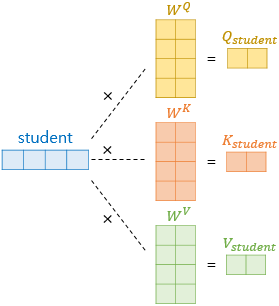

## 1-4) 스케일드 닷-프로덕트 어텐션 구하기

각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구하게 됩니다. 그리고 이를 모든 Q 벡터에 대해서 반복합니다.


- 기존 어텐션 함수 / 특정 값(두 벡터의 내적값을 스케일링)<br>
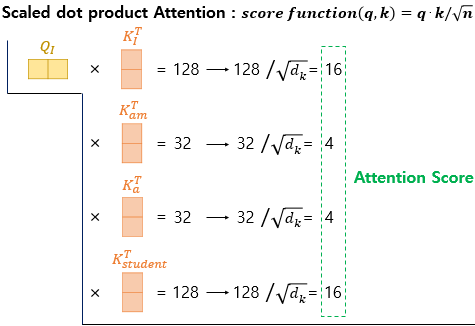



-> 단어 I 에 대한 Q 벡터가 모든 K 벡터에 대해 어텐션 스코어를 구함 ( 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지 보여주는 수치)

-> 다음으로, 어텐션 스코어에 소프트맥스 함수 사용하여 어텐션 분포행렬을 얻은 뒤에 V 행렬과 곱합니다.

==> 단어 I에 대한 context vector를 구해짐(어텐션 값)
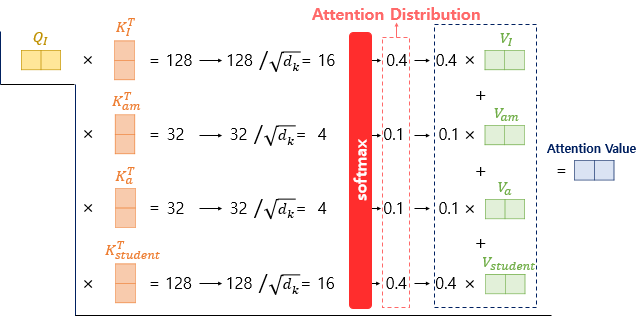

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights


## 1_5) 패딩 마스크

스케일드 닷 프로덕트 어텐션 함수 내부의 mask라는 값을 사용함. 이 연산은 무엇?

-> 이는 입력 문장에 < PAD > 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산

-> 트랜스포머에서는 Key의 경우에 < PAD > 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 함

-> 마스킹이란 어텐션에서 제외하기 위해 값을 가린다는 의미

-> 마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어주는 것

-> 현재 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0에 굉장히 가까운 값이 되어 단어 간 유사도를 구하는 일에 < PAD > 토큰이 반영되지 않게 됨


## 1_6) 패딩 마스크를 구현하는 방법
입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것





In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


scaled_dot_product_attention 함수가 정상 작동하는지 테스트

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성

np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

#  Query에 해당하는 temp_q의 값 [0, 10, 0]은 Key에 해당하는 temp_k의 두번째 값 [0, 10, 0]과 일치 할 때
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [ ]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

#Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
#Key의 세번째 값과, 네번째 값 두 개의 값 모두와 일치하는 값일 때
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

# Query의 값은 Key의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가짐

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
#하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용했을 때
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 1_7) 멀티 헤드 어텐션 구현하기

dmodel의 차원을 num_heads개로 나누어 dmodel/num_heads의 차원을 가지는 Q, K, V에 대해서 num_heads개의 병렬 어텐션을 수행<br>
--> 한 번의 어텐션보다 병렬로 사용하여 더 효과적
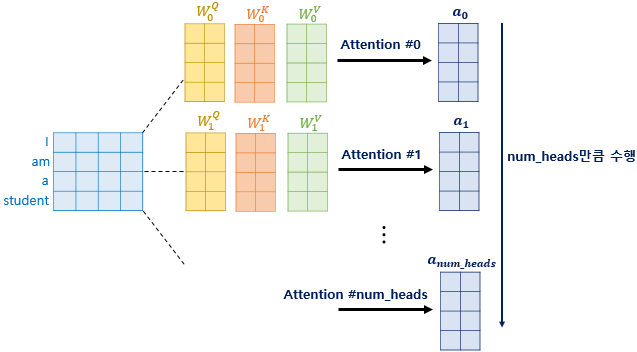

1.WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.

2.지정된 헤드 수(num_heads)만큼 나눈다(split)<br>
3.스케일드 닷 프로덕트 어텐션.<br>
4.나눠졌던 헤드들을 연결(concatenatetion)한다.<br>
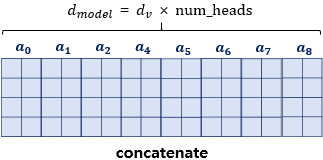

5.가중치 행렬 WO에 해당하는 밀집층을 지나게 한다.

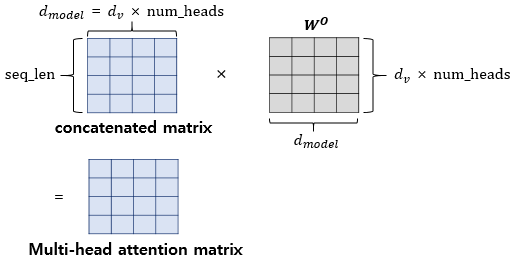

트랜스포머는 다수의 인코더를 쌓은 형태인데(논문에서는 인코더가 6개), 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있기 때문


==> 여러번의 어텐션을 병렬로 사용하는 것이 더 효과적

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

## 1_8) 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)
두번째 서브층

1. 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층
2. 완전 연결 FFNN(Fully-connected FFNN)
3. 수식 : 
FFNN(x) = MAX(0, x{W_{1}} + b_{1}){W_2} + b_2 <br>
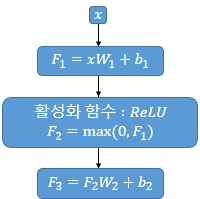
<br>
  -> x 는 앞서 멀티 헤드 어텐션의 결과로 나온 (seq_len, dmodel)의 크기를 가지는 행렬
  
  -> 가중치 행렬 W1은 (dmodel, dff)의 크기
  
  -> 가중치 행렬 W2은 (dff, dmodel)의 크기
  
  -> 논문에서 은닉층의 크기 dff = 2,048 
  
  -> 매개변수 W1, b1, W2, b2는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용됩니다. 하지만 인코더 층마다는 다른 값을 가짐

In [ ]:
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정입니다.
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

## 1_9)인코더 구현
-> 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용

-> 인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망

-> 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행


In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 1_10)인코더 쌓기

인코더 층을 num_layers개만큼 쌓는 코드

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#2. 디코더

1. 인코더가 총 num_layers 만큼 층 연산을 순차적으로 한 후에 마지막 츠으이 인코더 출력을 디코더에게 전달. 디코더는 인코더가 보낸 출력을 각 디코더 층 연산에 사용함. 디코더도  num_layers만큼 연산 수행.


2. 디코더는 총 세 개의 서브층으로 구성
 
 -> 첫번째 서브층: 멀티 헤드 어텐션, mask의 인자값으로 look_ahead_mask

 -> 두번째 서브층: 멀티 헤드 어텐션, mask의 인자값으로 padding_mask

 -> 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행

##2_1) 디코더의 첫번째 서브층 : 셀프 어텐션과 룩-어헤드 마스크

룩-어헤드 마스크의 필요성 :

seq2seq의 디코더 RNN과 비교 했을 때,
기존의 RNN은 현재 시점을 기준으로 그 이전에 입력된 단어들만 참고 할 수 있지만,

트랜스포머의 디코더는 문장 행렬로 입력을 한꺼번에 받기 때문에 혀냊 시점의 단어를 예측 할 때, 

현재 기준에서 미래 시점의 단어도 참고 할 수 있음.

즉, 현재 시점의 예측에서 미래에 있는 단어들을 참고 하지 못하도록 마스킹 함.



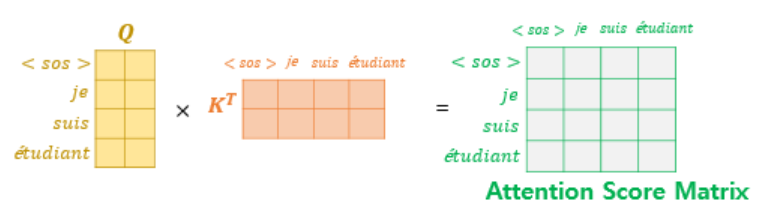

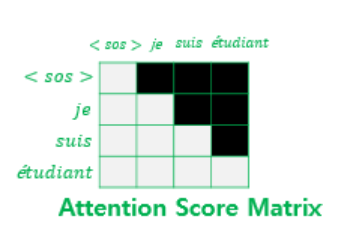

##2_2) 룩 어헤드 마스크 (look-ahead mask)의 구현

스케일드 닷 프로덕트 어텐션 함수에 mask라는 인자로 전달

->마스킹을 하고자 하는 위치에는 1을 리턴

->마스킹을 하지 않는 위치에는 0을 리턴

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

룩 어헤드 마스크 및 패딩 마스크 테스트

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


##2_3) 디코더의 두번째 서브층 : 인코더-디코더 어텐션


두번째 서브층의 인코더-디코더 어텐션 : 

query = 디코더의 첫번째 서브층의 결과 행렬로 부터 얻음 / 

key, value = 인코더의 마지막 층에서 온 행렬로 얻음


##2_4) 디코더 구현하기

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

##2_5) 디코더 쌓기


In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#3. 트랜스포머

##3_1) 트랜스포머 구현

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 3_2) 트랜스포머 하이퍼파라미터

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

##3_3) 트랜스포머 손실 함수 
크로스 엔트로피 사용

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

##3_4)트랜스포머 학습률

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

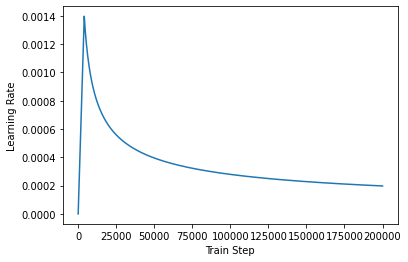

In [ ]:
#예시
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")